# Importando bibliotecas

In [46]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

# Definindo funcoes e classes auxiliares

In [48]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)   

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['car','wheel','light','windows']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,dsize=(128,128),interpolation=cv2.INTER_AREA)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask,dsize=(128,128),interpolation=cv2.INTER_AREA)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [40]:
x_train_dir = "dataset_segmentacao/car-segmentation/train/images/"
y_train_dir = "dataset_segmentacao/car-segmentation/train/masks/"

x_valid_dir = "dataset_segmentacao/car-segmentation/valid/images/"
y_valid_dir = "dataset_segmentacao/car-segmentation/valid/masks/"

x_test_dir = "dataset_segmentacao/car-segmentation/test/images/"
y_test_dir = "dataset_segmentacao/car-segmentation/test/masks/"

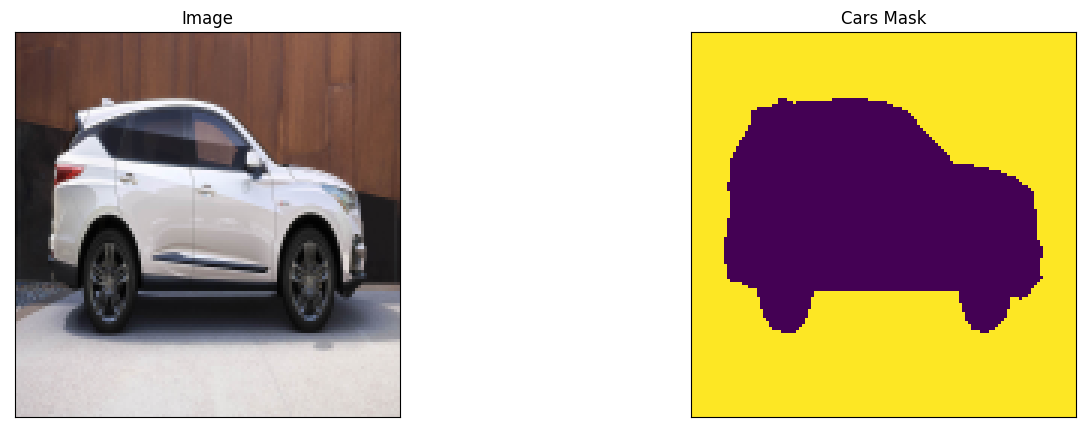

In [31]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    # sky_mask=mask[..., 1].squeeze(),
    # background_mask=mask[..., 2].squeeze(),
)

In [35]:
os.environ["SM_FRAMEWORK"] ="tf.keras"
import segmentation_models as sm    

Segmentation Models: using `tf.keras` framework.


# Definindo parametros do modelo

In [36]:
BACKBONE = 'resnet18'
BATCH_SIZE = 4
CLASSES = ['car']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [37]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

44920640/44920640 [==============================] - 3s 0us/step


# Definindo métricas e otimizador

In [38]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()

total_loss = sm.losses.binary_focal_dice_loss if n_classes == 1 else sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

# Instanciando dataset

In [49]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    # augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    # augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
# assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
# assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

# Treinando o modelo

In [50]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
33/33 [==============================] - 74s 2s/step - loss: 0.4124 - iou_score: 0.6771 - f1-score: 0.8033 - val_loss: 0.6335 - val_iou_score: 0.1036 - val_f1-score: 0.1867 - lr: 1.0000e-04
Epoch 2/10
33/33 [==============================] - 58s 2s/step - loss: 0.2647 - iou_score: 0.8145 - f1-score: 0.8959 - val_loss: 0.5122 - val_iou_score: 0.3716 - val_f1-score: 0.5351 - lr: 1.0000e-04
Epoch 3/10
33/33 [==============================] - 58s 2s/step - loss: 0.2014 - iou_score: 0.8930 - f1-score: 0.9424 - val_loss: 0.2889 - val_iou_score: 0.7542 - val_f1-score: 0.8545 - lr: 1.0000e-04
Epoch 4/10
33/33 [==============================] - 59s 2s/step - loss: 0.1641 - iou_score: 0.9239 - f1-score: 0.9599 - val_loss: 0.2077 - val_iou_score: 0.8456 - val_f1-score: 0.9137 - lr: 1.0000e-04
Epoch 5/10
33/33 [==============================] - 58s 2s/step - loss: 0.1374 - iou_score: 0.9438 - f1-score: 0.9709 - val_loss: 0.1630 - val_iou_score: 0.8944 - val_f1-score: 0.9420 - lr: 1.0000

# Visualizando resultados do treino

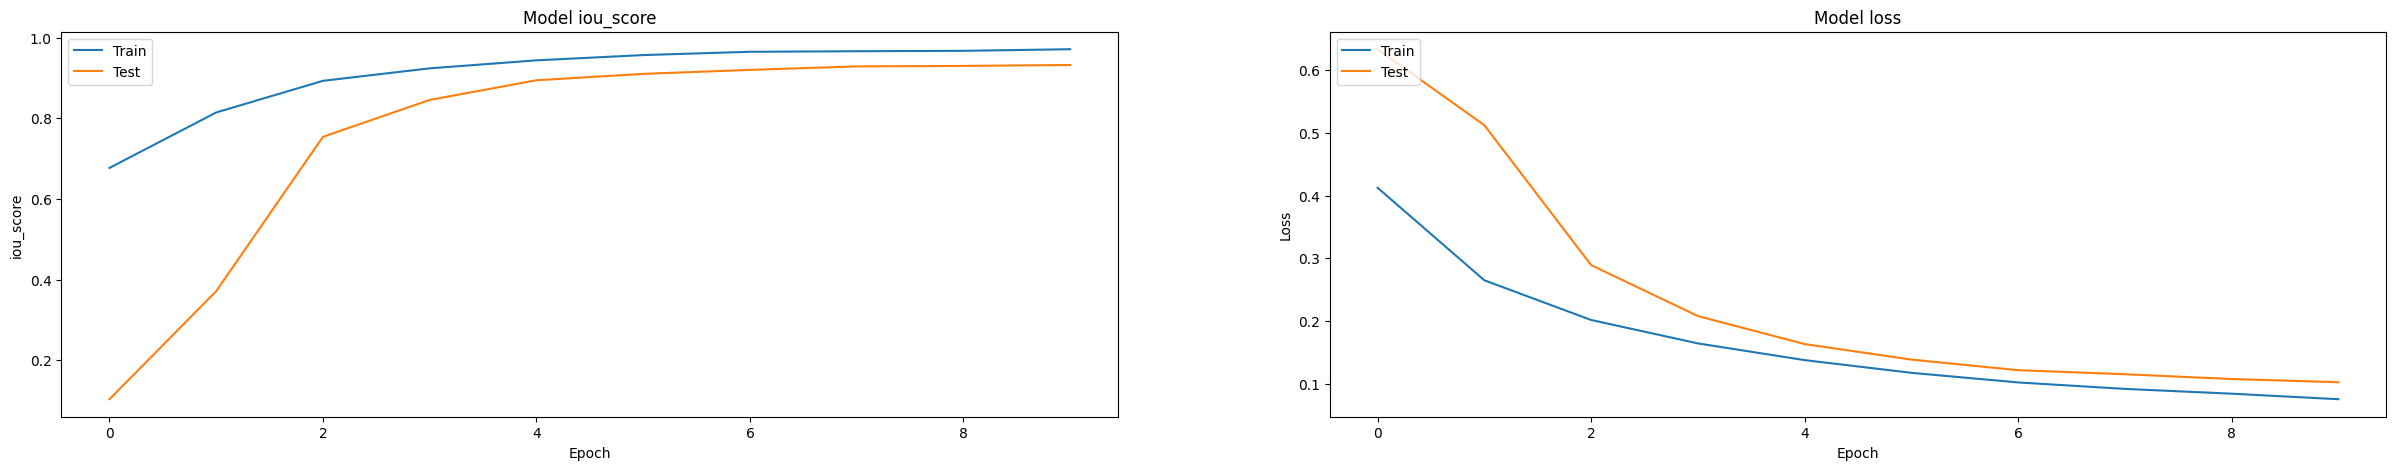

In [51]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Instanciando teste

In [52]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    # augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [53]:
# load best weights
model.load_weights('best_model.h5') 

In [54]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

C:\Users\dpatricio\AppData\Local\Temp\ipykernel_15448\3518042878.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_dataloader)


Loss: 0.097686
mean iou_score: 0.94212
mean f1-score: 0.96942


# Visualizando alguns testes

1/1 [==============================] - 1s 995ms/step


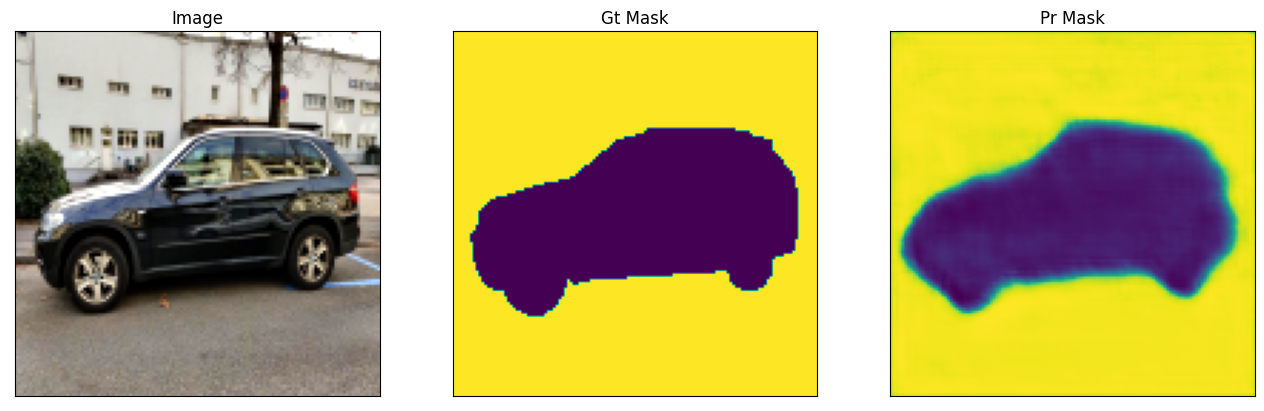

1/1 [==============================] - 0s 79ms/step


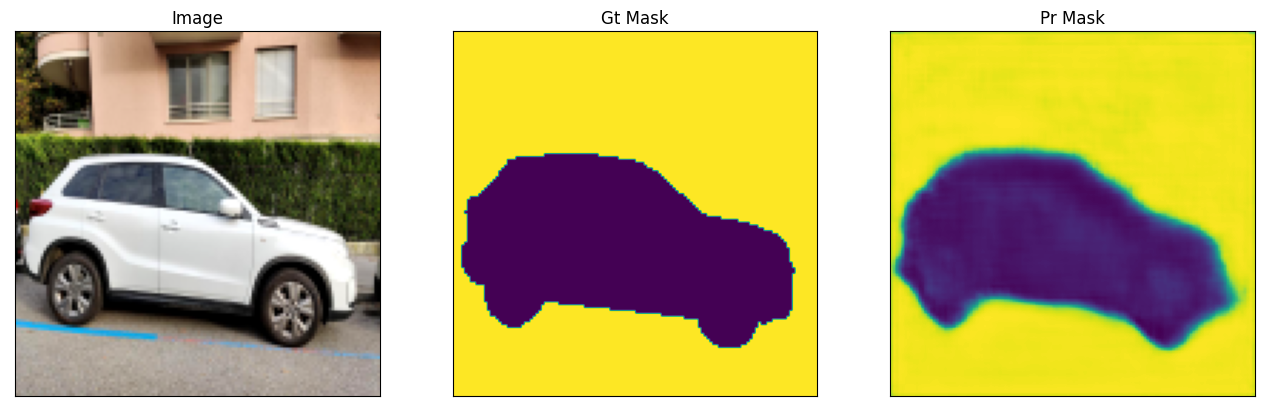

1/1 [==============================] - 0s 82ms/step


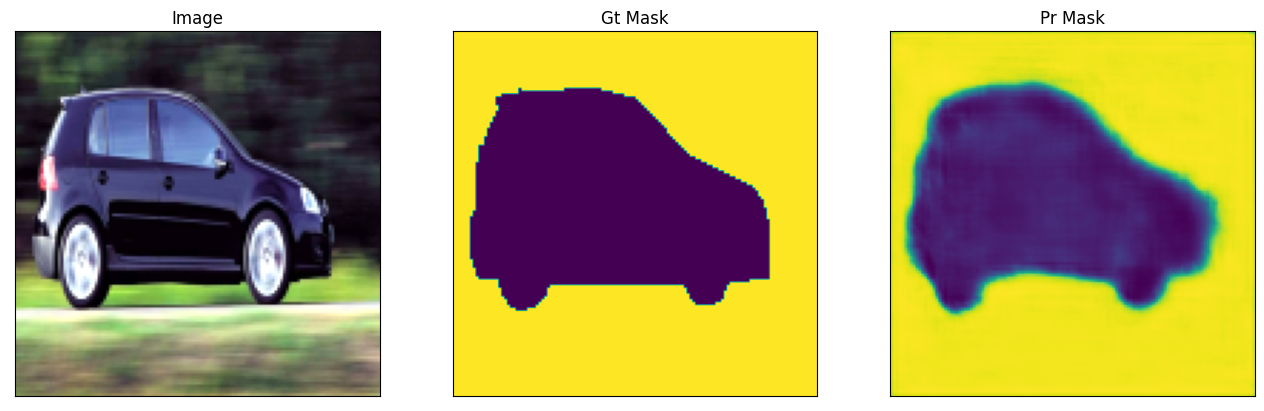

1/1 [==============================] - 0s 79ms/step


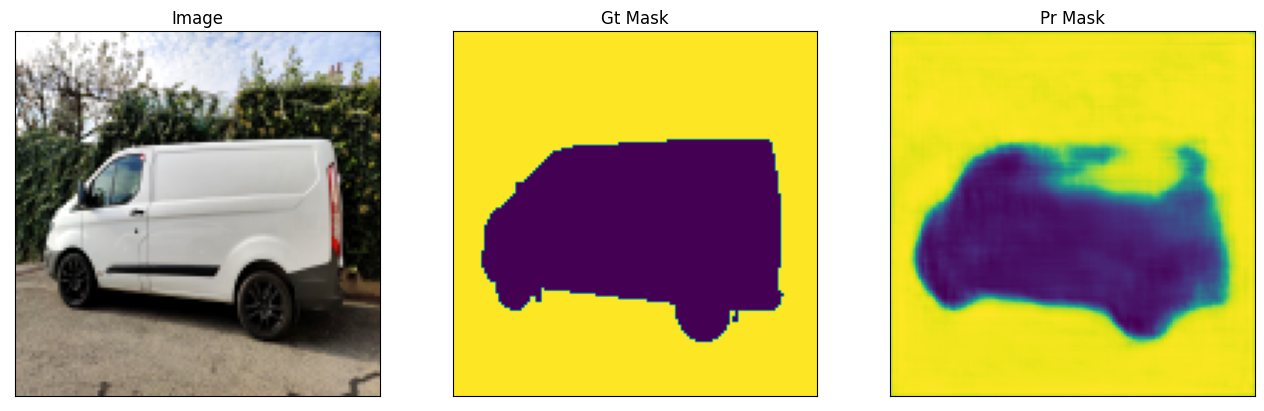

1/1 [==============================] - 0s 78ms/step


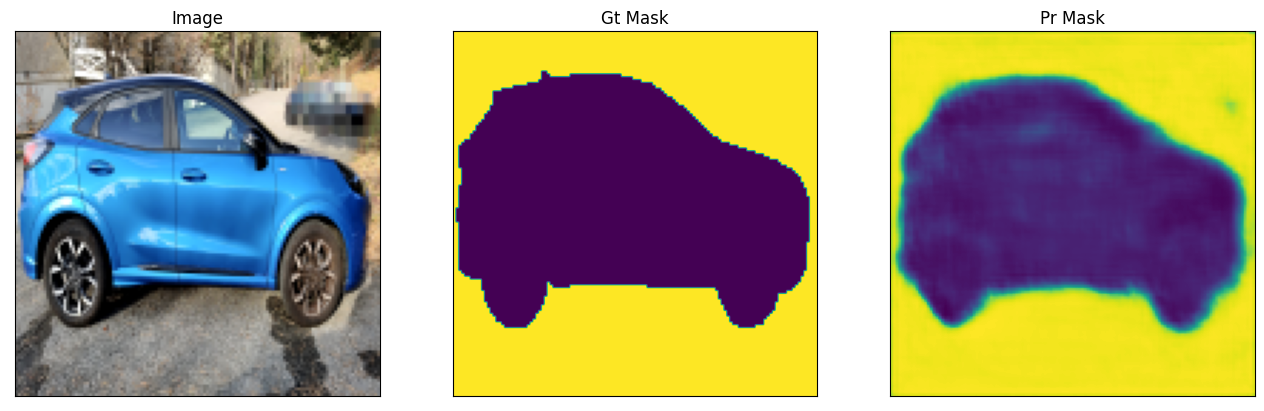

In [55]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )